In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from ifu_helpers import *

In [2]:
%matplotlib ipympl

In [3]:
def make_subpupil_mirrors(x, y, d, p):
    """Assume coordinate system has already been transformed to follow the chief
    ray (see alpha, beta, gamma values in p).
    
    Parameters
    ----------
    d: float
        On-axis distance to subpupil mirrors. Must be > 0.
    """
    return conic_3d(x, y, c, k, alpha, beta, 0)

def subpupil_angles():
    alpha = 0
    beta = 0
    return alpha, beta

In [3]:
def func_transfer(t, xt, yt, l, m, n, p):
    """The roots of this function give the value of t.
    """
    xs = xt + t*l
    ys = yt + t*m
    zs = t*n
    return make_image_slicer(xs, ys, p) - zs

def conic_3d_transfer(xt, yt, l, m, n, c, k, alpha, beta, gamma, soln=0):
    """Returns the transfer distance. Because the equation for t is a quadratic,
    there are two possible solutions. We almost always want the solution that
    corresponds to a smaller value of t (+ )

    See Cheatham 1980.
    """
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    gamma = convert_angle(gamma) * np.pi/180
    if abs(gamma) <= np.pi/2:
        sgn = 1
    else:
        sgn = -1
        
    # Determine the off-axis distance
    if (abs(c) > 1e-10):
        # If curvature is very small, it's basically a plane so no need to shift coordinates
        r = 1 / c
        y0 = r*np.sin(alpha) / (1+np.cos(alpha))
        x0 = r*np.sin(beta) / (1+np.cos(beta))
        y = y + y0
        x = x + x0
    # Sign of solution also depends on whether concave or convex
    sgn = sgn * abs(c) / c

    cosg = np.cos(gamma)
    cosg2 = cosg*cosg
    sing = np.sin(gamma)
    sing2 = sing*sing
    
    xi = cosg2 + (1+k)*sing2
    A = c*(sing2 + (1+k)*cosg2)
    dsol = A*n*n - 2*l*n*k*c*sing*cosg + c*l*l*xi + m*m*c
    fsol = -xt*n*k*c*sing*cosg - n*cosg + l*sing + c*xt*l*xi + yt*m*c
    gsol = 2*xt*sing + c*xt*xt*xi + c*yt*yt
    # In regions where the roots are undefined, we set the sag to 0
    # This means that the transfer distance is 0
    return np.where(bsol**2-4*asol*csol < 0, 0, gsol/(-fsol + sgn*np.sqrt(fsol*fsol - dsol*gsol)))

In [4]:
def ray_trace_slicer(xt, yt, l, m, n, p):
    if abs(n) < 1e-13:
        # Ray is moving perpendicular to the z-axis! This is an unusual case.
        # Set bounds on potential xs and ys to edges of the image slicer
        xsize, ysize = get_slicer_size(p)
        xmin, xmax = -xsize/2, xsize/2
        ymin, ymax = -ysize/2, ysize/2
        
        if l < 0: xmin *= -1; xmax *= -1  # propagate right to left
        if m < 0: ymin *= -1; ymax *= -1  # propagate bottom to top
        
    else:
        # Get maximum and minimum possible values of xs and ys
        zmin, zmax = find_global_extrema_slicer(p)
        tmin = zmin / n
        xmin, ymin = xt + tmin*l, yt + tmin*m
        tmax = zmax / n
        xmax, ymax = xt + tmax*l, yt + tmax*m

    # Get starting and ending rows and columns
    nc_min, ns_min = get_slicer_index(xmin, ymin, p)
    nc_max, ns_max = get_slicer_index(xmax, ymax, p)
    
    # Check if the ray is always out of bounds
    n_sperc = p.n_each * p.n_rows  # number of slices per column
    if (nc_min < 0 and nc_max < 0) or (nc_min >= p.n_cols and nc_max >= p.n_cols):
        # x-value of the ray is too high or low
        return
    if (ns_min < 0 and ns_max < 0) or (ns_min >= n_sperc and ns_max >= n_sperc):
        # y-value of the ray is too high or low
        return

    # Ray is in bounds at least some of the time. Start from the min col and slice
    # indices and check solutions until we hit the max
    nc_test, ns_test = nc_min, ns_min
    x_test, y_test = xt, yt

    dcol = abs(nc_max - nc_test)       # Number of col indices to iterate
    dslice = abs(ns_max - ns_tst)      # Number of slice (row) indices to iterate
    sgnc = (nc_max - nc_min) / dcol    # keep track of signs...
    sgns = (ns_max - ns_min) / dslice
    
    while (abs(nc_max - nc_test) >= 0 and abs(ns_max - ns_test) >= 0):
        
        check_transfer_solution(nc_test, ns_test, xt, yt, l, m, n, p)

        # Crossover point between current column and next one
        x_cross = nc_test * (p.dx + p.gx_width) + (1 + sgnc) * dx / 2
        # Calculate how many slices we can iterate over before we need to switch cols

        if abs(l) < 1e-13:
            # Parallel to y-axis. No need to switch columns.
            pass
        else:
            # y-intercept between ray and column
            y_cross = yt + (x_cross - x_test) * m / l
            get_slicer_index
            

        
        
        # Need to increment col and slice indices. Figure out what happens to the
        # column index if we try to increment by dy. By definition, ns_new should
        # be offset from ns_test by 1
        nc_new, ns_new = get_slicer_index(x_test, y_test + p.dy*sgns, p)

        # If the column is the same, no special behavior required.
        nc_test = nc_new
        ns_test = ns_new

        # If the column was incremented by 1, try incrementing by dx instead 
        nc_new, ns_new = get_slicer_index(x_test + p.dx*sgnc, y_test, p)
        if ns_new == ns_test:
            # Slice number is the same. 
        
        
        
        

    # If none of the solutions worked, the ray must have gone through a gap, i.e.,
    # it hit a wall. 
    if p.trace_gaps:
        pass

def check_transfer_solution(col_num, slice_num, xt, yt, l, m, n, p):
    # Compute the transfer distance for this slice
    alpha, beta, gamma = get_slice_angles(ns_test, nc_test)
    t_test = conic_3d_transfer(xt, yt, l, m, n, p.c, p.k, alpha, beta, gamma)

    # Check if it's a valid zero of the transfer function for the complete slicer
    result = func_transfer(t, xt, yt, l, m, n, p)
    if result is not None:
        if abs(result - t_test) > 1e-13:
            # Found the solution! Compute the angles
            return
    return

def increment_slice_for_ray(l, m, p):
    pass

IndentationError: expected an indented block after 'if' statement on line 73 (3299013710.py, line 82)

In [5]:
def get_slices_hit(xt, yt, zmin, zmax, l, m, n, p):
    """Returns which slices have been potentially hit by a ray.
    """
    # Get maximum and minimum values of x and y from the given xt, yt
    if abs(n) < 1e-13:
        # Ray missed
        return -1
    tmin = zmin / n
    xmin, ymin = xt + tmin*l, yt + tmin*m
    tmax = zmax / n
    xmax, ymax = xt + tmax*l, yt + tmax*m

    n_slices = p.n_each*p.n_rows  # number of slices per column
    # Get slice and column number for each set of coordinates
    nc_min, ns_min = get_slicer_index(xmin, ymin, p)
    nc_max, ns_max = get_slicer_index(xmax, ymax, p)
    # If ray is never in bounds, it missed
    if (nc_min < 0 and nc_max < 0) or (nc_min >= p.n_cols and nc_max >= p.n_cols):
        return -1
    if (ns_min < 0 and ns_max < 0) or (ns_min >= n_slices and ns_max >= n_slices):
        return -1
    # In bounds at least some of the time. For simplicity, set out of bounds indices to the
    # nearest row and column index
    nc_min = max(0, min(p.n_cols, col_num_min))
    ns_min = max(0, min(p.n_rows*p.n_each, col_num_min))
    nc_max = max(0, min(p.n_cols, col_num_min))
    ns_max = max(0, min(p.n_rows*p.n_each, col_num_min))
    
    # Figure out which slices could have been hit by the array
    slices_hit = np.zeros((n_slices, p.n_cols))    
    # Check differences in row and column values
    dcol = abs(nc_max - nc_min)
    dslice = abs(ns_max - ns_min)
    # If dcol = 0, no need to find crossover regions between columns
    if dcol == 0:
        if ns_min == ns_max:
            # Only one slice hit
            slices_hit[ns_min, nc_min] = 1
        if ns_min > ns_max:
            # Need to go backwards
            slices_hit[ns_max:ns_min, nc_min] = 1
        else:
            slices_hit[ns_min:ns_max, nc_min] = 1
        return slices_hit
    if l == 0:
        # If l==0, then dcol should be zero which is handled above.
        # Prevent division by zero just in case...
        return slices_hit
    
    # Increment min slice and column numbers until we reach max. Sign tells us which way
    # to iterate.
    c_iter = (nc_max - nc_min) / dcol
    s_iter = (ns_max - ns_min) / dslice
    dx_col = (p.dx + p.gx_width) // p.n_cols
    for i in range(dcol):
        c = nc_min + c_iter*(i+1)     # Get new column to cross over to
        x_cross = c * dx_col          # x-value where the column crosses over
        y_cross = yt + (xc - xt) / l  # y-intercept between ray and column
        junk, s = get_slicer_index(x1, y1, p)
        # Mark slices in initial column until reaching the crossover slice
        while (dslice > 0 and ns_min <= s):
            slices_hit[ns_min, nc_min] = 1
            ns_min += s_iter
            dslice -= 1
        # Add crossover slice to next column as well, then continue
        col_min = c
        slices_hit[ns_min, nc_min] = 1
    return slices_hit

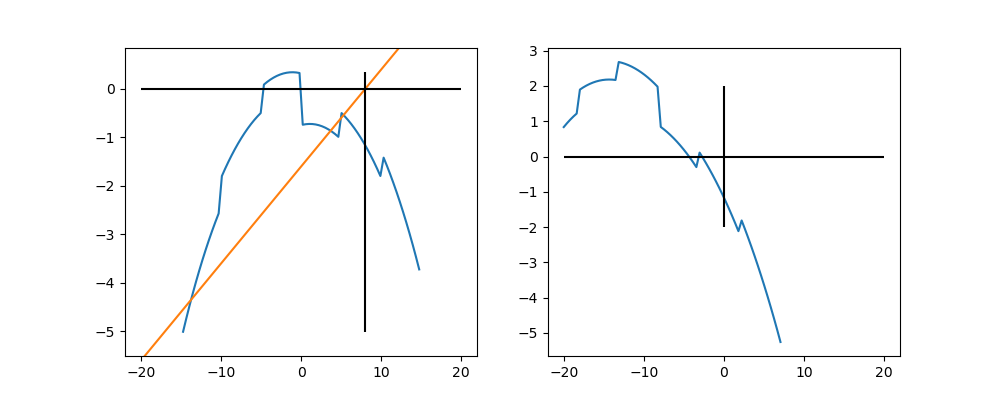

In [5]:
n_each = 3
n_rows = 2
n_cols = 1
mode = 1
dalpha = 10
dbeta = -10
dgamma = 10
alpha_cen = 0
beta_cen = 0
gamma_cen = 0
dx = 15
dy = 5
r = -25
c = 1/r
k = 0
xgap_width = 2
xgap_depth = np.nan
ygap_width = 0
ygap_depth = 2
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)

xt = 3
y = np.linspace(-20, 20, 100)
surf = np.zeros(len(y))
for i,y1 in enumerate(y):
    surf[i] = make_image_slicer(xt, y1, p)

t = np.linspace(-20, 20, 100)
yt = 8
l = 0
m = 1
n = 0.2
ray = (y-yt)*n/m

l = l / np.sqrt(l*l+m*m+n*n)
m = m / np.sqrt(l*l+m*m+n*n)
n = n / np.sqrt(l*l+m*m+n*n)

feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = func_transfer(t1, xt, yt, l, m, n, p)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(y, surf)
axs[0].plot(y, ray)
axs[0].set_ylim(np.nanmin(surf)-0.5, np.nanmax(surf)+0.5)
axs[0].vlines(yt, np.nanmin(surf), np.nanmax(surf), colors='k')
axs[0].hlines(0, y[0], y[-1], colors='k')

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -2, 2, colors='k')
#axs[1].set_ylim(-10, 10)

plt.show()

In [43]:
surface

array([-0.83892638, -0.84192509, -0.8448626 , -0.8477389 , -0.85055399,
       -0.85330788, -0.85600057, -0.85863205, -0.86120233, -0.8637114 ,
       -0.86615927, -0.86854594, -0.8708714 , -0.87313566, -0.87533872,
       -0.87748058, -0.87956124, -0.88158069, -0.88353895, -0.885436  ,
       -0.88727186, -0.88904651, -0.89075996, -0.89241222, -0.89400328,
       -0.89553314, -0.89700179, -0.89840926, -0.89975552, -0.90104059,
       -0.90226446, -0.90342713, -0.90452861, -0.90556889, -0.90654798,
       -0.90746587, -0.90832256, -0.90911807, -0.90985237, -0.91052548,
       -0.9111374 , -0.91168813, -0.91217766, -0.912606  , -0.91297315,
       -0.91327911, -0.91352387, -0.91370744, -0.91382982, -0.91389101,
       -0.91389101, -0.91382982, -0.91370744, -0.91352387, -0.91327912,
       -0.91297317, -0.91260603, -0.91217771, -0.9116882 , -0.9111375 ,
       -0.91052561, -0.90985254, -0.90911828, -0.90832283, -0.9074662 ,
       -0.90654838, -0.90556938, -0.90452919, -0.90342782, -0.90

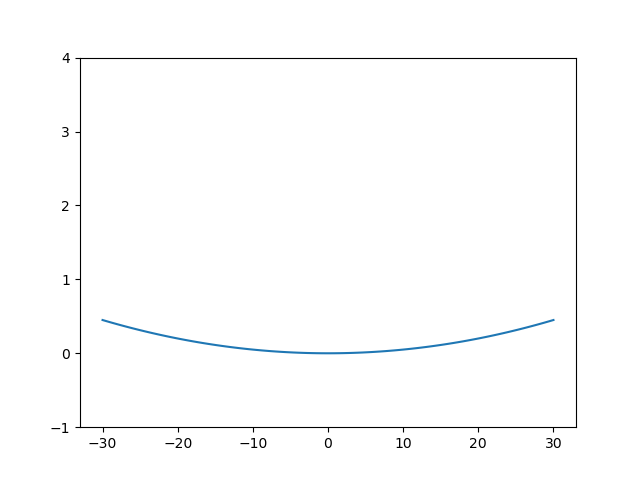

In [49]:
xs = np.linspace(-30,30,100)
y0 = 0
r = 1000
c = 1/r
k = -1
alpha = 0
beta = 0
gamma = 0

surface = conic_3d(xs, y0, c, k, alpha, beta, gamma)

#print(conic_3d_sag_critical_x_y(c, k, 0, 2, gamma))

#idx = np.argmin(surface)
#print(xs[idx])

plt.figure()
plt.plot(xs, surface)
plt.ylim(-1,4)
#plt.scatter(xs[idx], surface[idx], c='r')
plt.show()

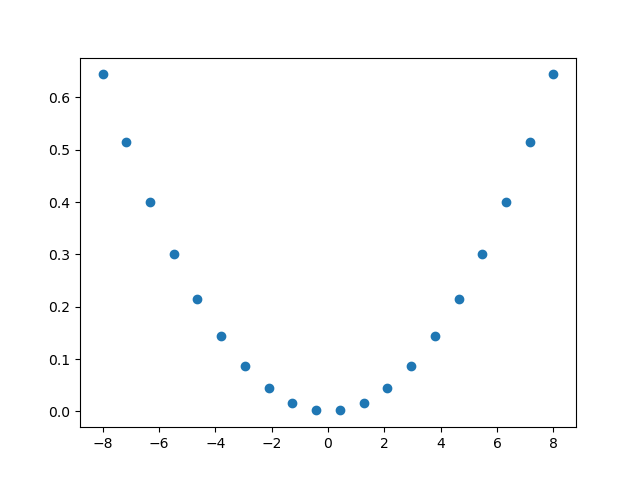

In [9]:
n_each = 1
n_rows = 1
n_cols = 1
mode = 0
dalpha = -20
dbeta = 0
dgamma = 10
alpha_cen = 0
beta_cen = 0
gamma_cen = 0
dx = 15
dy = 5
r = 50
c = 1/r
k = -1
gx_width = 0
gx_depth = np.nan
gy_width = 0
gy_depth = np.nan
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, gx_width, gx_depth, gy_width, gy_depth)

N = 20
r = 20
k = 0
t = -10

y = np.linspace(-8, 8, N)
x = np.linspace(-8, 8, N)
z = conic_3d(x, 0, c, k, 0, 0, 0)

plt.figure()
plt.scatter(x, z)
plt.show()

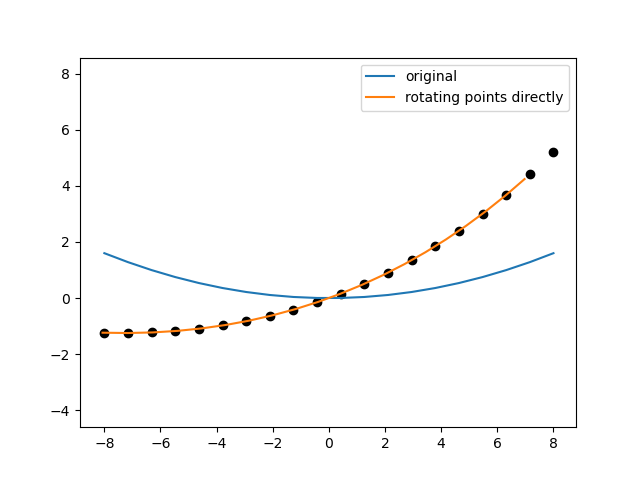

In [17]:
N = 20
r = 20
k = -1
t = 20

# perform the rotation manually with a rotation matrix
x1 = np.linspace(-8, 8, N)
y1 = []
x2 = []
y2 = []
#y3 = []
trad = -t*np.pi/180

for i in range(N):
    y1.append(conic(x1[i],r,k))
    xnew = x1[i]*np.cos(trad)+y1[i]*np.sin(trad)
    ynew = -x1[i]*np.sin(trad)+y1[i]*np.cos(trad)
    x2.append(xnew)
    y2.append(ynew)
    #y3.append(rotated_conic(x1[i], r, k, t))

y3 = conic_3d(x1, 0, 1/r, k, 0, 0, t)
plt.figure()
plt.plot(x1,y1,label='original')
plt.plot(x2,y2,label='rotating points directly')
plt.scatter(x1,y3,c='k')
#plt.vlines([-2,0,2], -1, 1)
#plt.ylim(0,8)
#plt.xlim(-8,8)
plt.axis('equal')
plt.legend()
#plt.savefig("rotated_conics.png",dpi=300,facecolor="white")
plt.show()

In [13]:
print(find_global_extrema_slicer(p))
print((np.nanmin(Z), np.nanmax(Z)))

(-1.5429975231111848, 7.099552996045867)
(-1.5430279404587852, 7.090008043265858)


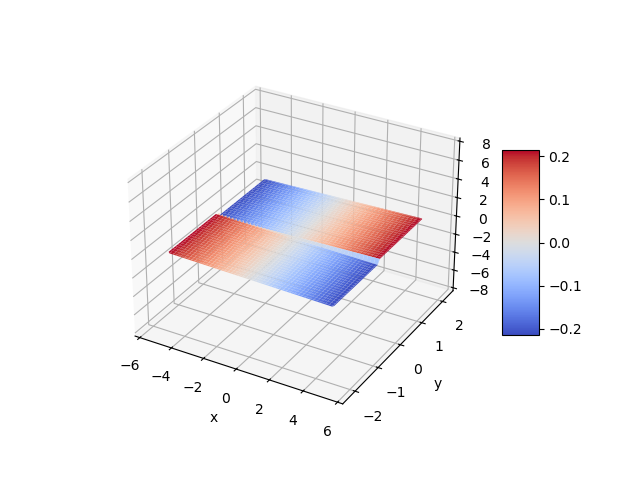

In [51]:
n_each = 2
n_rows = 1
n_cols = 1
mode = 1
trace_gaps = False
dalpha = 2
dbeta = 2
dgamma = 5
alpha_cen = 0
beta_cen = 0
gamma_cen = 0
dx = 10
dy = 2
r = 60000
c = 1/r
k = -2
xgap_width = 0
xgap_depth = -0.5
ygap_width = 0
ygap_depth = -0.8
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_gaps, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)
xsize, ysize = get_slicer_size(p)

N = 200

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.scatter(9.487179487179485,-4.364548494983277,-0.6999614810235664, c='g')
#ax.scatter(9.487179487179485,14.899665551839465,3.8157755724491054, c='g')
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-8, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [46]:
def rotatebackward3d(x, y, z, alpha,beta):
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    cosa = np.cos(alpha)
    cosa2 = cosa*cosa
    sina = np.sin(alpha)
    sina2 = sina*sina
    cosb = np.cos(beta)
    cosb2 = cosb*cosb
    sinb = np.sin(beta)
    sinb2 = sinb*sinb
    
    # Inverse transformation matrix for a 3D rotation about the global x- and y-axes
    det = cosa2*cosb2 + cosb2*sina2 + cosa2*sinb2 + sina2*sinb2
    a = (cosa2*cosb + cosb*sina2) / det
    b = sina*sinb / det
    c = -1*cosa*sinb / det
    d = (cosa*cosb2 + cosa*sinb2) / det
    f = (cosb2*sina + sina*sinb2) / det
    g = (cosa2*sinb + sina2*sinb) / det
    h = -1*cosb*sina / det
    m = cosa*cosb / det
    xp = a*x + b*y + c*z
    yp = d*y + f*z
    zp = g*x + h*y + m*z
    #print([[a,b,c],[0,d,f],[g,h,m]])
    xp = a*x + b*y + c*z
    yp = d*y + f*z
    zp = g*x + h*y + m*z
    return xp, yp, zp

def rotateforward3d(x,y,z,alpha,beta):
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    cosa = np.cos(alpha)
    cosa2 = cosa*cosa
    sina = np.sin(alpha)
    sina2 = sina*sina
    cosb = np.cos(beta)
    cosb2 = cosb*cosb
    sinb = np.sin(beta)
    sinb2 = sinb*sinb
    
    xp = x*cosb + y*sinb
    yp = x*sina*sinb + y*cosa - z*cosb*sina
    zp = -x*cosa*sinb + y*sina + z*cosa*cosb
    return xp, yp, zp


alpha=10
beta=20

N = 30
x = np.linspace(-10,10,N)
y = np.linspace(-10,10,N)

xold = []
yold = []
zold = []
xnew = []
ynew = []
znew = []

Z = np.zeros((N,N))

for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        z1 = rotated_conic_3d(x1,y1,20,20,0,0,0,0)
        Z[i,j] = z1
        x1po, y1po, z1po = rotateforward3d(x1,y1,z1,alpha,beta)
        x1p, y1p, z1p = rotatebackward3d(x1po, y1po, z1po, alpha, beta)
        xold.append(x1po)
        yold.append(y1po)
        zold.append(z1po)
        xnew.append(x1p)
        ynew.append(y1p)
        znew.append(z1p)
    
X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.scatter(xold,yold,zold)
#ax.scatter(xnew,ynew,znew)
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(0, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

NameError: name 'rotated_conic_3d' is not defined